In [5]:
import pandas as pd
import re
from spaczz.matcher import FuzzyMatcher
import spacy
import string

import os
from pathlib import Path
import duckdb as ddb
from pandas_plots import tbl, pls, hlp

hlp.show_package_version()
os.environ['THEME']='dark'

dir_db=Path("C://temp") if hlp.get_os(hlp.OperatingSystem.WINDOWS) else Path(os.path.expanduser("~/tmp"))

# ! use either clin or fake data
file_db_clin = dir_db/'2025-04-07_data_clin.db'
# file_db_clin = dir_db/'fake_clin_data.db'

if not file_db_clin.exists():
    raise FileNotFoundError(f"File not found: {file_db_clin}")

🐍 3.11.7 | 📦 pandas: 2.2.3 | 📦 numpy: 1.26.4 | 📦 duckdb: 1.2.2 | 📦 pandas-plots: 0.12.23 | ❌ connection_helper: Not found


In [6]:
con = ddb.connect()
_=con.execute("PRAGMA disable_progress_bar;")
_=con.execute(f"ATTACH DATABASE '{file_db_clin}' as clin; set schema 'clin';")

In [7]:
sub_data = con.sql("select distinct Bezeichnung from Substanz").to_df()
display(sub_data)

# sub_data = pd.read_csv("C:/Python/Substanzen/Test_Daten.csv", sep = ";", encoding="utf-8")
sub_data.head()

,Bezeichnung
0,Prednisolon
1,Decitabin
2,Lenalidomid
3,Trastuzumab deruxtecan
4,Temozolomid
...,...
4175,Sacitizumab
4176,INN - Paclitaxel
4177,Mesn
4178,HD-AC


,Bezeichnung
0,Prednisolon
1,Decitabin
2,Lenalidomid
3,Trastuzumab deruxtecan
4,Temozolomid


In [8]:
URL_LINK = "https://gitlab.opencode.de/robert-koch-institut/zentrum-fuer-krebsregisterdaten/cancerdata-references/-/raw/main/data/v2/Klassifikationen/substanz.csv?ref_type=heads"
reference_list = pd.read_csv(URL_LINK, sep=";")
reference_list.head()

,therapieart,substanz,code
0,HO,Abarelix,L02BX01
1,IM,Abatacept,L04AA24
2,ZS,Abemaciclib,L01EF03
3,IM,Abetimus,L04AA22
4,HO,Abirateron,L02BX03


In [9]:
col_with_substances = sub_data["Bezeichnung"]
col_with_ref_substances = reference_list["substanz"]

In [ ]:
import re
import spacy
from spaczz.matcher import FuzzyMatcher

# ----------- Preparation Functions -----------

def prepare_free_text(input_col: pd.Series) -> pd.DataFrame:
    """Prepares data by renaming, stripping, and cleaning null or empty entries."""
    input_data = pd.DataFrame({
        "ID": range(1, len(input_col) + 1),
        "Original": input_col.fillna("NA").replace("", "NA")
    })
    input_data["Original"] = input_data["Original"].astype(str).str.strip()
    return input_data


def remove_short_words(text: str) -> str:
    return " ".join([word for word in text.split() if len(word) >= 3])


def find_5FU(text: str) -> str:
    pattern = (
        r"5 fu|5fu|5-fu|5_fu|Fluoruracil|flourouracil|5-fluoruuracil|"
        r"5-fluoro-uracil|5-fluoruuracil|5-fluoruracil|floururacil|"
        r"5-fluorounacil|flourouraci|5-fluourouracil"
    )
    return re.sub(pattern, "fluorouracil", text, flags=re.IGNORECASE)


def calciumfolinat_to_folin(text: str) -> str:
    return re.sub(r"\b(Calciumfolinat)\b", "folinsäure", text, flags=re.IGNORECASE)


def find_gemcitabin(text: str) -> str:
    return re.sub(r"Gemcibatin(?:e)?(?: Mono)?", "gemcitabin", text, flags=re.IGNORECASE)


def find_Paclitaxel_nab(text: str) -> str:
    return re.sub(r"\bnab[\s\-]?Paclitaxel\b", "Paclitaxel nab", text, flags=re.IGNORECASE)


# ----------- Preprocessing Pipeline -----------

def preprocess_data(col_with_free_text: pd.Series) -> pd.DataFrame:
    df = prepare_free_text(col_with_free_text)
    processed = (
        df["Original"]
        .apply(find_5FU)
        .apply(find_gemcitabin)
        .apply(find_Paclitaxel_nab)
        .apply(calciumfolinat_to_folin)
        .apply(remove_short_words)
        .str.strip()
    )
    df["Preprocessed_text"] = processed
    return df


# ----------- Matching Function -----------

def get_matches(preprocessed_data: pd.DataFrame, ref_substance: pd.Series,
                threshold=0.8, max_per_match_id=2, only_first_match=False) -> pd.DataFrame:
   
    nlp = spacy.blank("en")
    matcher = FuzzyMatcher(nlp.vocab)

    # Add each reference substance to matcher
    for sub in ref_substance.dropna().astype(str):
        matcher.add(sub, [nlp(sub)])

    results = []

    for _, row in preprocessed_data.iterrows():
        text = row["Preprocessed_text"]
        original = row["Original"]
        doc = nlp(text)
        matches = matcher(doc)

        # Filter and sort matches
        matches_filtered = [m for m in matches if m[3] >= threshold * 100]
        matches_sorted = sorted(matches_filtered, key=lambda x: x[3], reverse=True)

        result_row = {"Original": original}
        result_row["Preprocessed"] = text
        match_id_counts = {}
        match_idx = 1

        for match_id, start, end, ratio, _ in matches_sorted:
            count = match_id_counts.get(match_id, 0)
            if count >= max_per_match_id:
                continue

            result_row[f"Hit{match_idx}"] = match_id
            result_row[f"Mapped_to{match_idx}"] = doc[start:end].text
            result_row[f"Similarity{match_idx}"] = ratio

            match_id_counts[match_id] = count + 1
            match_idx += 1

        results.append(result_row)
    
    out = pd.DataFrame(results)

    if only_first_match:
        cols_to_keep = ["Original", "Preprocessed", "Hit1", "Mapped_to1", "Similarity1"]
        available_columns = [col for col in cols_to_keep if col in out.columns]
        dta_col_selected = out[available_columns]
        dta_col_selected.columns = [re.sub(r"\d+$", "", col) for col in dta_col_selected.columns]        
        return(dta_col_selected)
        
    return out

preprocessed_out = preprocess_data(col_with_substances)
final_output = get_matches(preprocessed_out, col_with_ref_substances, only_first_match=True)

,Original,Preprocessed,Hit,Mapped_to,Similarity
0,Prednisolon,Prednisolon,Prednisolon,Prednisolon,100.0
1,Decitabin,Decitabin,Decitabin,Decitabin,100.0
2,Lenalidomid,Lenalidomid,Lenalidomid,Lenalidomid,100.0
3,Trastuzumab deruxtecan,Trastuzumab deruxtecan,Trastuzumab deruxtecan,Trastuzumab deruxtecan,100.0
4,Temozolomid,Temozolomid,Temozolomid,Temozolomid,100.0


🔵 *** df: final_output ***  
🟣 shape: (4_180, 5) columns: ['Original' 'Preprocessed' 'Hit' 'Mapped_to' 'Similarity']  
🟣 duplicates: 0  
🟣 uniques: [{Original: 4_180 Preprocessed: 4_036 Hit: 332 Mapped_to: 974 Similarity: 20}]  
🟣 missings: [{Original: 0 Preprocessed: 0 Hit: 1_701 Mapped_to: 1_701 Similarity: 1_701}]  
--- column uniques (all)  
🟠 index [0, 1, 2, 3, 4,]  
🟠 Original(4_180|object)   ['(1', '(8mg/kg) Bortezumib', '(Abatacept)', '(Darolutamid)', '(Denosumab)',]  
🟠 Preprocessed(4_036|object)   ['', '(8mg/kg) Bortezumib', '(Abatacept)', '(Darolutamid)', '(Denosumab)',]  
🟠 Hit(333|object)   ['<NA>', 'Abarelix', 'Abatacept', 'Abemaciclib', 'Abetimus',]  
🟠 Mapped_to(975|object)   ['-CSF', '/-NIVOLUMAB', '5Fluorouracil', '6Mercaptopurin', '<NA>',]  
🟠 Similarity(20|float64)   [80.0, 81.0, 82.0, 83.0, 84.0,]  
--- column stats (numeric)  
Similarity -> min: 80.0 | lower: 100.0 | q25: 100.0 | median: 100.0 | mean: 97.856 | q75: 100.0 | upper: 100.0 | max: 100.0 | std: 4.576 | 

,Original,Preprocessed,Hit,Mapped_to,Similarity
0,Prednisolon,Prednisolon,Prednisolon,Prednisolon,100.0
1,Decitabin,Decitabin,Decitabin,Decitabin,100.0
2,Lenalidomid,Lenalidomid,Lenalidomid,Lenalidomid,100.0


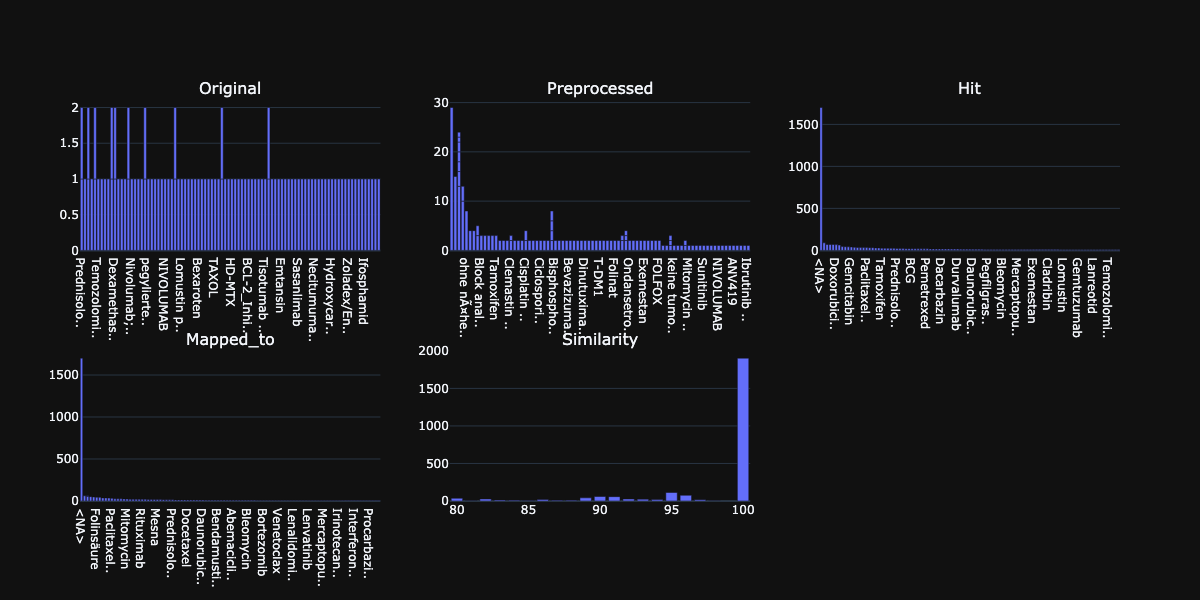

In [13]:
tbl.describe_df(
    final_output,
    "final_output",
    top_n_uniques=5,
    top_n_chars_in_index=10,
)

In [11]:
final_output.to_csv(".local/out1.csv", index=False)